In [1]:
import math
import numpy as np
import random
import pandas as pd
import datetime

In [3]:
import torch
torch.manual_seed(1017)
dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

d:\workspace\SakuraGit\python\torch\stocknet\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cuda:0


In [18]:
class FXNextMEANDiffDataset:
    def __init__(self,next_index=1, short_window=12, long_window=26, isTraining = True, seed=0, mode="default"):
        self.next = next_index
        random.seed(seed)
        rates = pd.read_csv('/mnt/landisk/data/fx/NextBoaderPossibility/fx_USDJPY_5_2020-08-03T23-05-00_to_2021-12-04T07-50-00.csv', header=0, index_col=0, parse_dates=True)
        self.rowdata = rates
        #rates["ema"] = rates.close.windows(10).mean()
        rates["short_ema"] = self.EMA(rates.close, short_window)
        rates["long_ema"] = self.EMA(rates.close, long_window)
        diff_array = rates.diff().dropna()
        data = pd.DataFrame(diff_array, columns=['time', 'open', 'high', 'low', 'close', 'tick_volume', 'spread', 'real_volume', 'short_ema', "long_ema"])
        data = data.drop(columns=['time', 'real_volume'])
        data.tick_volume, _, _ = self.minmaxNormalization(rates.tick_volume)
        data.spread,_,_ = self.minmaxNormalization(rates.spread)
        self.all_data = data
        length = len(self.all_data)
        print(length)
            
        self.dataRange = datetime.timedelta(days=2)
        self.dims = 5
        self.mode = mode
        INTERVAL_DAYS = 2
        MINUTES_SPAN = 5

        totalMinutes = INTERVAL_DAYS * 24 * 60
        self.span  = int(totalMinutes/MINUTES_SPAN)+1
        
        ##select random indices.
        self.indices = random.sample(range(self.span, length - self.span -1), k=length - self.span*2 -1)
        if isTraining:
            self.fromIndex = self.span
            self.toIndex = int(length*0.7)
        else:
            self.fromIndex = int(length*0.7)+1
            self.toIndex = length+1
        self.outputFunc = self.__getAns__

    def EMA(self, data, interval):
        sema = [-1 for i in range(0,interval-1)]
        lastValue = data[0:interval].sum()/interval
        sema.append(lastValue)
        alpha = 2/(interval+1)
        for i in range(interval, len(data)):
            lastValue = lastValue * (1-alpha) + data[i]*alpha
            sema.append(lastValue)
        return sema
        
    def __getDiffArray__(self, data):
        for i in range(1,len(data)):
            data[i] - data[i-1]
        
    def __rateToArray__(self, value):
        output = [0 for i in range(0,3000)]
        i = round((value -0.85)*10000)
        if i >= 3000:
            i = 2999
        elif i < 0:
            i = 0
        output[i] = 1
        return output
        
    def __len__(self):
        return self.toIndex - self.fromIndex
    
    def __getAns__(self,ndx):
        if type(ndx) == int:
            indicies = slice(ndx, ndx+1)
            index = self.indices[ndx]
            return self.all_data[['short_ema', 'long_ema']].iloc[index+self.next].values

        elif type(ndx) == slice:
            indicies = ndx
        ans = []
        for index in self.indices[indicies]:
            ans.append(self.all_data[['short_ema', 'long_ema']].iloc[index+self.next].values)
        return ans
        
    def __getRowData__(self, ndx):
        inputs = []
        if type(ndx) == slice:
            for index in self.indices[ndx]:
                inputs.append(self.rowdata[index+1-self.span:index+1].values.tolist())
        else:
            index = ndx
            inputs = self.rowdata[index+1-self.span:index+1].values.tolist()

        return inputs
    
    def __getInputs__(self, ndx):
        inputs = []
        data = self.all_data
        if type(ndx) == int:
            indicies = slice(ndx, ndx+1)
            for index in self.indices[indicies]:
                inputs.append(data[['short_ema', 'long_ema']][index+1-self.span:index+1].values.tolist())
            return inputs[0]
        elif type(ndx) == slice:
            indicies = ndx
            for index in self.indices[indicies]:
                inputs.append(data[['short_ema', 'long_ema']][index+1-self.span:index+1].values.tolist())
            return inputs
    
    def __getActialIndex__(self,ndx):
        inputs = []
        if type(ndx) == slice:
            for index in self.indices[ndx]:
                inputs.append(index)
        else:
            inputs = self.indices[ndx]

        return inputs
    
    def __getitem__(self, ndx):
        ins = np.array(self.__getInputs__(ndx), dtype=np.dtype('float32'))
        outputs = np.array(self.outputFunc(ndx), dtype=np.dtype('float32'))
        return torch.tensor(ins, device=device).to(dtype=dtype), torch.tensor(outputs, device=device).to(dtype=dtype)
        #return ins, outputs
    
    def minmaxNormalization(self, data):
        if type(data) == np.ndarray:
            temp_data = data[~np.isnan(data)]
        elif type(data) == pd.core.series.Series:
            temp_data = data.dropna()
        else:
            print(f"unkown type: {type(data)}")
            temp_data = data
        X_max, X_min = max(temp_data), min(temp_data)
        data_norm = (data - X_min) / (X_max - X_min)
        return data_norm, X_min, X_max

    def convertAnsToBoaderValue(self,rate):
        ansValue = rate*(self.ansmax - self.ansmin) + self.ansmin
        return ansValue

In [19]:
import torch
import torch.nn as nn
from torch.optim import SGD

class Predictor(nn.Module):
    def __init__(self, inputDim, hiddenDim, outputDim):
        super(Predictor, self).__init__()

        self.rnn = nn.LSTM(input_size = inputDim,
                            hidden_size = hiddenDim,
                            batch_first = True)
        self.rnn.to(device)
        self.output_layer = nn.Linear(hiddenDim, outputDim)
        self.output_layer.to(device)
    
    def forward(self, inputs, hidden0=None):
        batch_size, seq_len = inputs.shape[0], inputs.shape[1]
        output, (hidden, cell) = self.rnn(inputs, hidden0) #LSTM層
        output = self.output_layer(output[:, -1, :]) #全結合層

        return output

In [66]:
from torch.utils.data import DataLoader
next_step = 3
ds = FXNextMEANDiffDataset(next_step)
batch_size = 64
hidden_size = 50
dataloader = DataLoader(ds, batch_size=batch_size)
training_size = 10000 #traning dataのデータ数
model = Predictor(2, hidden_size, 2)

99935


In [68]:
criterion = nn.MSELoss() #評価関数の宣言
optimizer = torch.optim.Adam(model.parameters(), lr=1e-06)

<IPython.core.display.Javascript object>


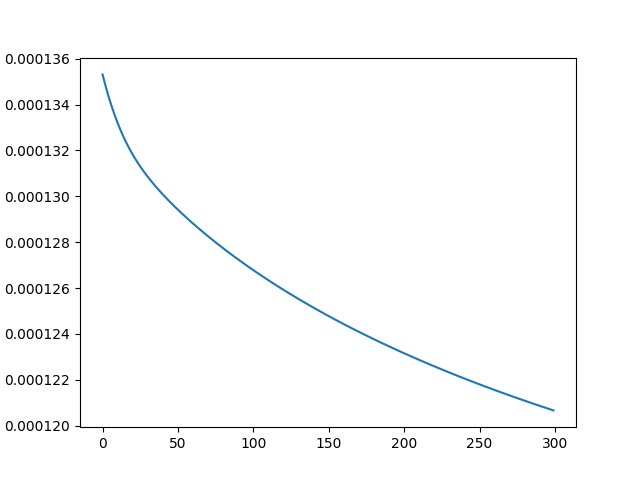

2022-02-07 11:23:31.954448: 1 loss: 0.0001353164307030779
2022-02-07 11:30:18.470016: 2 loss: 0.00013505521951045896
2022-02-07 12:31:06.475343: 11 loss: 0.00013319852568644984
2022-02-07 13:36:31.017797: 21 loss: 0.00013182124256999462
2022-02-07 14:46:22.770585: 31 loss: 0.00013084994932983254
2022-02-07 15:51:58.226608: 41 loss: 0.00013008051591429813
2022-02-07 16:57:33.047714: 51 loss: 0.00012941559042736536
2022-02-07 18:43:35.668350: 61 loss: 0.00012881355217604534
2022-02-07 21:41:16.378123: 71 loss: 0.00012825637005766438
2022-02-08 00:11:04.478259: 81 loss: 0.00012773499070835198
2022-02-08 01:13:45.340860: 91 loss: 0.0001272441649794368
2022-02-08 02:16:17.205687: 101 loss: 0.00012678014522512408
2022-02-08 03:19:26.355723: 111 loss: 0.00012634005704570975
2022-02-08 04:22:12.614264: 121 loss: 0.00012592148788115036
2022-02-08 05:24:40.196575: 131 loss: 0.0001255224928848829
2022-02-08 06:27:04.568357: 141 loss: 0.00012514132322102785
2022-02-08 07:27:54.528717: 151 loss: 0.

In [72]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import random

epochs_num = 300 #traningのepoch回数

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
losses = []

for epoch in range(epochs_num):
    
    # training
    running_loss = 0.0
    training_accuracy = 0.0
    first = np.random.randint(0, len(ds) - training_size)
    batch_training_size= int(training_size / batch_size)
    for data, label in dataloader:
        output = model(data)

        loss = criterion(output, label)
        #print(f"label: {label.shape}")
        #print(f"outut: {output.shape}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.data.item()
    losses.append(running_loss/batch_training_size)
    ax.clear()
    ax.plot(losses)
    fig.canvas.draw()
    ax.clear()
    ax.plot(losses)
    fig.canvas.draw()
    if epoch == 1 or epoch % 10 == 0:
        print(f'{datetime.datetime.now()}: {epoch + 1} loss: {running_loss/batch_training_size}')

In [57]:
%matplotlib notebook
def validate(model, val_loader, index=0):
    high_d = 0
    low_d = 0
    out_ = np.array([])
    ans_ = np.array([])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ion()

    fig.show()
    fig.canvas.draw()
    losses = []

    for name, loader in [("val", val_loader)]:
        with torch.no_grad():
            correct = 0
            count = 0
            for values, anses in loader:
                outputs = model(values)
                ans = anses
                temp = outputs -ans
                high_d += temp.mean()
                #output: [batchDim, outputDim]
                out_ = np.append(out_, outputs[:,index].to('cpu').detach().numpy().copy())
                ans_ = np.append(ans_, ans[:,index].to('cpu').detach().numpy().copy())
                #high_rates = numpy.append(high_rates, rates[:,0].to('cpu').detach().numpy().copy())
                #low_rates = numpy.append(low_rates, rates[:,1].to('cpu').detach().numpy().copy())
                count += 1
    print('--------------------------------------------------')
    print(f'high: {high_d/count}')
    print(f'mean diff: {(ans_ - out_).mean()}, var: {(ans_ - out_).var()}')
    print('--------------------------------------------------')
    ax.clear()
    ax.plot(ans_,out_, 'ro', color="red")
    fig.canvas.draw()
    return ans_, out_

99935


<IPython.core.display.Javascript object>


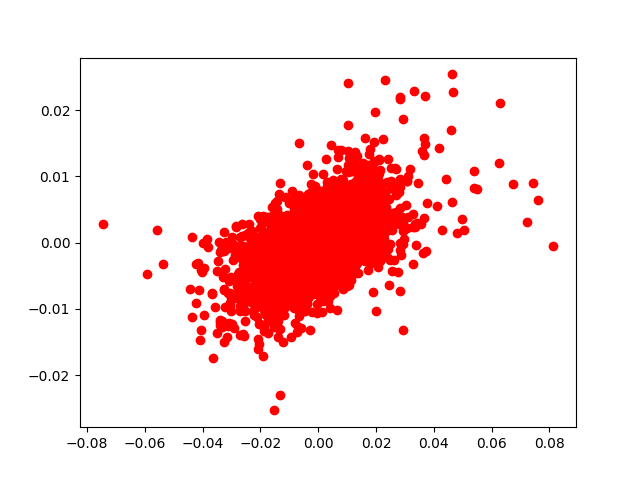

--------------------------------------------------
high: -0.00011756820458685979
mean diff: 0.00012420834970780847, var: 2.9894996250748634e-05
--------------------------------------------------


In [70]:
val_ds = FXNextMEANDiffDataset(next_index=next_step, isTraining=False)
val_dl = DataLoader(val_ds, batch_size = batch_size)
ans, out = validate(model, val_dl, 0)

<IPython.core.display.Javascript object>


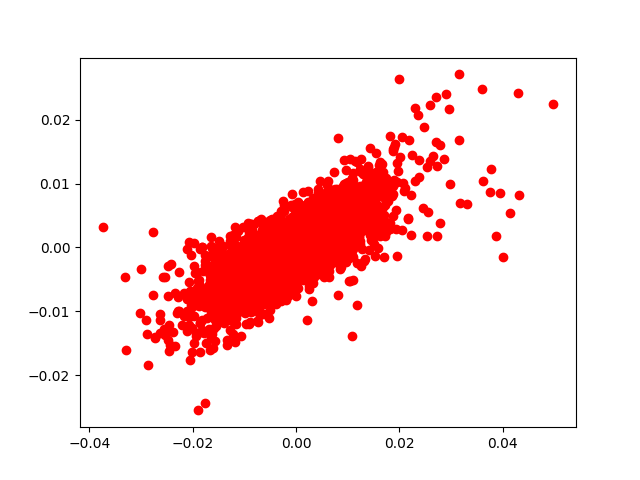

--------------------------------------------------
high: -0.00011756820458685979
mean diff: 0.00011195656152342281, var: 8.402784865631504e-06
--------------------------------------------------


In [71]:
if val_dl == None:
    val_ds = FXNextMEANDiffDataset(False)
    val_dl = DataLoader(val_ds, batch_size = batch_size)
ans, out = validate(model, val_dl, 1)

In [40]:
torch.save(model.state_dict(), f'fx_DiffNextEMAs_{next_step}step_LSTM_5_2days_v1')

In [45]:
dummy_input, dummy_output = ds[0:2]
print(model(dummy_input))

tensor([[0.0014, 0.0025],
        [0.0062, 0.0046]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [47]:
out

array([ 0.00135838,  0.00248083,  0.00615656, ...,  0.00604817,
        0.00115243, -0.00030353])